# 군집분석

엘보우 차트를 통해 K 값을 설정하더라도 주관인 만큼 (+-1~2) 정도의 여유를 잡을 것

`k-means 파라미터 : n_clusters=6(군집6개), n_init=10, max_iter=100`

n_clusters : 군집의 갯수, n_init : 초기 중심위치 수, random_state : 시드 값 고정(재현성)

## 패키지 참조

In [71]:
from pandas import DataFrame,read_csv,read_excel,merge,melt,pivot_table, concat
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import sys
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from factor_analyzer.factor_analyzer import calculate_kmo

import matplotlib.cm as cm
from sklearn.metrics import homogeneity_score, completeness_score 
from sklearn.metrics import v_measure_score, adjusted_rand_score
from scipy.spatial import ConvexHull

## 폰트세팅

In [72]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.unicode_minus"] = False

## 데이터

In [73]:
origin=read_excel('행정동병합최종(반포본동).xlsx')
origin.head(2)

,시도명,시군구코드,시군구명,행정동코드,행정동코드_수정,읍면동명,생성일자,말소일자,지하철역_수,의료기관_수,...,세대당공원면적minmax,수변점수,행정동별버스정류장수,행정동별유통업체수,공공자전거대여소수,인구밀도,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,서울특별시,11110,종로구,1111051500,11110515,청운효자동,20081101,0,0,11,...,0.352898,0,32,0,3,4552.529183,0.002648,0.068435,0.114798,0.212495
1,서울특별시,11110,종로구,1111053000,11110530,사직동,19880423,0,2,75,...,0.063554,0,27,0,12,7611.382114,0.006464,0.041923,0.333275,0.038269


In [74]:
origin.columns

Index(['시도명', '시군구코드', '시군구명', '행정동코드', '행정동코드_수정', '읍면동명', '생성일자', '말소일자',
       '지하철역_수', '의료기관_수', '사회복지시설_수', '계(명)', '면적 (k㎡)', '구성비 (%)',
       '행정동별_공원수', '공공체육시설_수', '문화시설_수', '학교_수', '사업체_수', '개소 (공영+민영)',
       '면수 (공영+민영)', '하천및한강여부', '아동인구(0~9세)', '노인인구(65세이상)', '장애인_인구',
       '세대당공원면적', '보육시설수', '세대당공원면적minmax', '수변점수', '행정동별버스정류장수', '행정동별유통업체수',
       '공공자전거대여소수', '인구밀도', '여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax',
       '접근성지수minmax', '환경자족성지수minmax'],
      dtype='object')

### 분석에 필요한 `읍면동명` 및 `지수` 변수 추출 

In [75]:
origin1=origin.filter(['읍면동명','여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax', '접근성지수minmax', '환경자족성지수minmax'])
origin1.head(2)

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,청운효자동,0.002648,0.068435,0.114798,0.212495
1,사직동,0.006464,0.041923,0.333275,0.038269


### 데이터 확인 및 전처리

실제 측정된 데이터인 만큼 결측치는 0 값으로 처리

In [76]:
origin1.isna().sum()

읍면동명                      0
여가생활지수minmax              1
사회적약자_지원_인프라_밀집도minmax    0
접근성지수minmax               0
환경자족성지수minmax             0
dtype: int64

In [77]:
origin2=origin1.fillna(0)
origin2.isna().sum()

읍면동명                      0
여가생활지수minmax              0
사회적약자_지원_인프라_밀집도minmax    0
접근성지수minmax               0
환경자족성지수minmax             0
dtype: int64

In [78]:
origin2.head(2)

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,청운효자동,0.002648,0.068435,0.114798,0.212495
1,사직동,0.006464,0.041923,0.333275,0.038269


## 군집분석 수행

### #1. `환경자족성지수 - 여가생활지수`

#### 지수 추출

In [79]:
origin2.columns

Index(['읍면동명', '여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax', '접근성지수minmax',
       '환경자족성지수minmax'],
      dtype='object')

In [80]:
origin3=origin2.copy()
# X값으로 공원면적,여가생활지수 지정
# 전체 행에서 index 1, -1 column만 추출
X = origin3.iloc[:,[1, -1]].values 
# 5개까지만 보이게
X[:5] 

array([[2.64751750e-03, 2.12494728e-01],
       [6.46393211e-03, 3.82685661e-02],
       [5.33216587e-03, 6.02142889e-01],
       [1.69869928e-03, 6.02142889e-01],
       [5.28773115e-04, 6.02860542e-01]])

#### 엘보우 메소드로 최적의 k값 예상

`Inertia`

KMeans 클러스터링의 성능 지표

각 샘플과 중점이 이동하는 자취 사이의 평균 제곱거리 측정 값

Inertia 값은 클러스터 수와 반비례 관계

클러스터 수를 늘려가면서 반복적으로 실행하면 값이 점점 작아진다

클러스터 수가 늘어감에 Inertia가 급격히 감소하고 어느 지점부터는 완만하게 감소하는 지점이 생기는데 이 지점이 최적 클러스터 수를 의미(=엘보우(Elbow))

<Axes: >

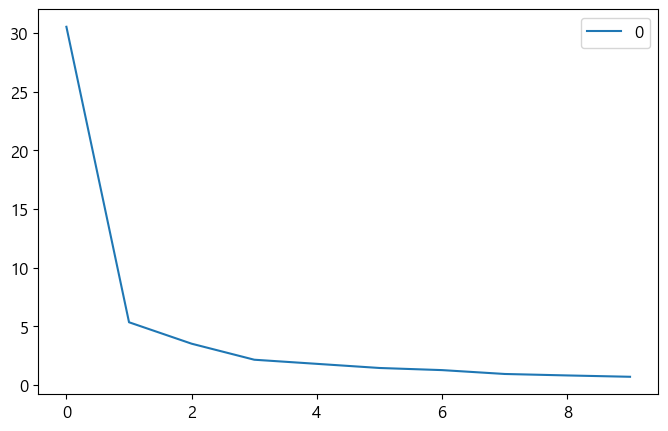

In [81]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k,n_init=10,max_iter=100).fit(X)
    value = kmeans.inertia_
    inertia.append(value)

DataFrame(inertia).plot()

> 엘보우 그래프 확인 결과 4개에서부터 완만히 떨어지는것으로 추정되어 군집수는 4개로 결정

#### 실루엣 계수로 k값에 따른 차이 확인

`실루엣 점수(계수)`

각 군집간의 거리가 얼마나 효율적으로 분리됐는지를 나타내는 지표

효율적 분리 : 어떤 한 점이 다른 군집과는 멀리 떨어져 있고, 동일 군집끼리는 서로 가깝게 잘 뭉쳐있음을 의미

개별 데이터가 같은 군집과는 얼마나 가깝고, 다른 군집의 데이터와는 얼마나 멀리 분리되어 있는가를 나타내는 값

sklearn은 전체 실루엣 점수의 평균값을 반환하는 `silhouette_score()` 함수를 제공

리턴값은 `-1~1`의 범위를 가지며 1에 가까울 수록 좋은 군집으로 판단

`0`인 경우는 클러스터가 겹치는 것을 의미

음수값은 일반적으로 샘플이 잘못된 클러스터에 할당되었음을 의미

> 실루엣 방법은 점수가 나오는 만큼 비교적 더 정확함

In [82]:
origin3_3=origin3.drop('읍면동명',axis=1)

In [83]:
score_list=[]

for k in range(2,11):
    kmeans=KMeans(n_clusters=k,n_init=10,max_iter=100)
    kmeans.fit(origin3_3)
    y_pred=kmeans.predict(origin3_3)
    score=silhouette_score(origin3_3,y_pred)
    score_list.append(score)

score_list

[0.7123356936016162,
 0.7249582977596429,
 0.6490569087450664,
 0.656291920039098,
 0.653661933350148,
 0.5169948959943795,
 0.45906896065637304,
 0.46859769572397103,
 0.4772936211825556]

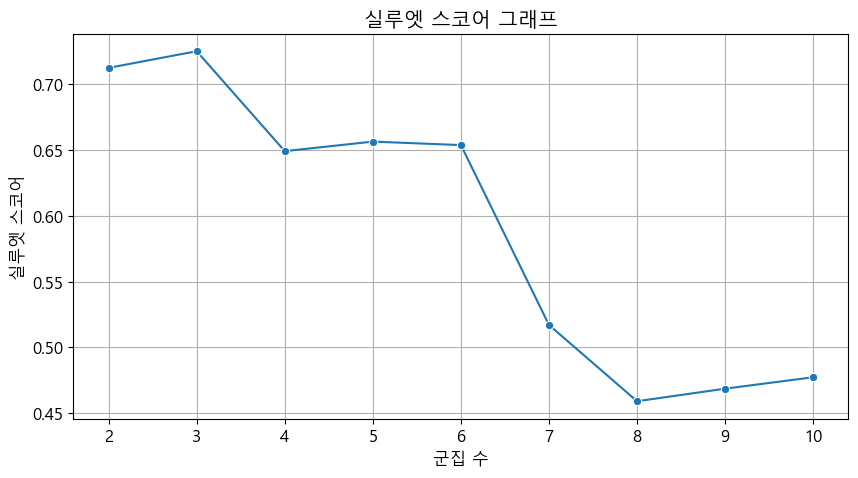

In [84]:
plt.figure(figsize=(10,5))
sb.lineplot(x=range(2,11),y=score_list,marker='o')
plt.title('실루엣 스코어 그래프')
plt.xlabel('군집 수')
plt.ylabel('실루엣 스코어')
plt.grid()
plt.show()
plt.close()

> 실루엣 스코어 확인 결과 마찬가지로 4로 설정하는게 가장 좋은 점수가 나옴. <br/> 추가 분석 결과 군집을 6으로 나눈 경우 더 이상적인 지역 분포를 나타내므로 K=6으로 설정

#### `n_clusters=6`으로 KMeans 군집 군석을 진행

n_clusters : 군집의 갯수, n_init : 초기 중심위치 수, random_state : 시드 값 고정(재현성)

In [85]:
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=100).fit(X)
origin3['cluster_id'] = kmeans.labels_
origin3.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
0,청운효자동,0.002648,0.068435,0.114798,0.212495,0
1,사직동,0.006464,0.041923,0.333275,0.038269,2
2,삼청동,0.005332,0.090426,0.342620,0.602143,1
3,부암동,0.001699,0.067935,0.157400,0.602143,1
4,평창동,0.000529,0.073234,0.135935,0.602861,1


c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


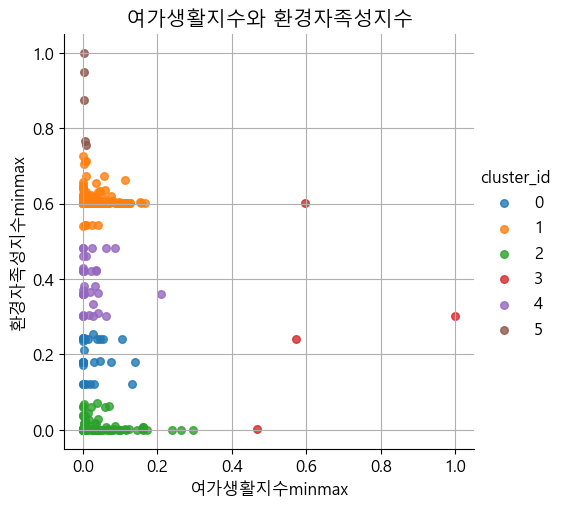

In [86]:
sb.lmplot(x='여가생활지수minmax', y='환경자족성지수minmax', data=origin3, 
          fit_reg=False, scatter_kws={"s": 30}, hue="cluster_id")
plt.title("여가생활지수와 환경자족성지수")
plt.grid()

> - 군집 분류는 기본적으로 서로 잘 모여있는게 이상적이나 우리 조는 특정 변수를 조합하여 만든 파생지수이므로 서로 몰려있으면서 수치가 높은 값을 찾아야 하는게 목표
> - 군집 확인 결과 비대칭적으로 몰려있는 것을 확인할 수 있음. <br>
> - 환경자족서지수가 가장 높은 군집 `0`과 비교적 환경자족성지수와 문화시민지수 모두 긍정적인 `4`번 군집을 분석에 사용.

> 이상적인 군집은 사분면을 기준으로 확실히 구분되며 몰려있는 것이다.<br>
다만, 현재 분석 결과에서 여가생확지수 분포는 비슷하게 도출되었다.<br>
따라서 환경자족성지수가 높으면서 여가생활지수가 긍정적인 군집 `3`을 이상적인 지역으로 선정.

### 수동 voting을 위한 xlsx 파일 생성

In [87]:
origin3[origin3['cluster_id']==0]
origin3[origin3['cluster_id']==4]

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
15,숭인제1동,0.000000,0.060028,0.134867,0.370980,4
53,행당제2동,0.209037,0.045674,0.075154,0.361708,4
55,금호1가동,0.000799,0.058367,0.101611,0.429124,4
65,화양동,0.021551,0.063416,0.085524,0.421500,4
72,자양제1동,0.000000,0.076379,0.045154,0.361342,4
81,전농제1동,0.062058,0.052807,0.096286,0.481714,4
82,전농제2동,0.031522,0.068208,0.073446,0.382903,4
99,상봉제1동,0.061386,0.047529,0.149345,0.301166,4
101,중화제1동,0.000000,0.071256,0.067862,0.301090,4
124,장위제1동,0.001083,0.035583,0.055287,0.421569,4


In [88]:
origin3_final = origin3[(origin3['cluster_id'] == 0) | (origin3['cluster_id'] == 4)]
len(origin3_final)

63

In [89]:
# origin3_final.to_excel('./교집합결과/여가생활,환경자족성지수voting1.xlsx')

### #2. `환경자족성지수 - 사회적약자_지원_인프라_밀집도`

#### 지수 추출

In [90]:
origin2.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,청운효자동,0.002648,0.068435,0.114798,0.212495
1,사직동,0.006464,0.041923,0.333275,0.038269
2,삼청동,0.005332,0.090426,0.342620,0.602143
3,부암동,0.001699,0.067935,0.157400,0.602143
4,평창동,0.000529,0.073234,0.135935,0.602861


In [91]:
origin4=origin2.copy()
Y = origin4.iloc[:,[-1,2]].values # x값으로 환경자족성지수,교통약자 지정
Y[:5]

array([[0.21249473, 0.06843491],
       [0.03826857, 0.04192329],
       [0.60214289, 0.09042634],
       [0.60214289, 0.06793525],
       [0.60286054, 0.0732343 ]])

#### 엘보우 메소드로 최적의 k값 예상

<Axes: >

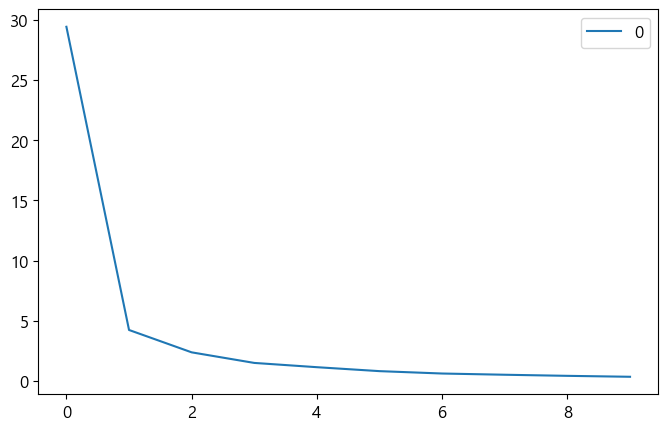

In [92]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k,n_init=10,max_iter=100).fit(Y)
    value = kmeans.inertia_
    inertia.append(value)

DataFrame(inertia).plot()

> 엘보우 그래프 확인 결과 분석가 판단하에 3개에서 완만하게 떨어지는것으로 판단하여 군집수는 3개로 결정함. <br/> 추가분석 결과 K=4일 경우 더 이상적인 군집을 형성.

#### 실루엣 스코어로 최적의 k값 예상

In [93]:
origin4_4=origin4.drop('읍면동명',axis=1)

실루엣 점수: 0.649


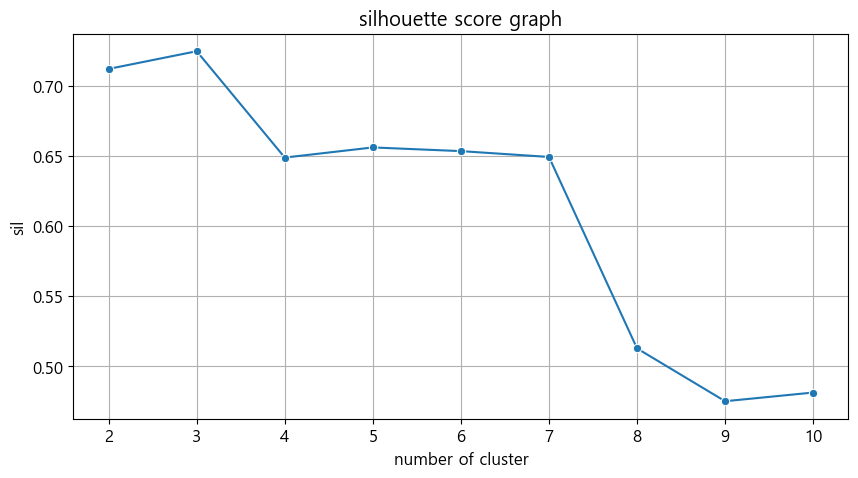

In [94]:
kmeans=KMeans(n_clusters=4,n_init=10,max_iter=100)
kmeans.fit(origin4_4)
y_pred=kmeans.predict(origin4_4)
score=silhouette_score(origin4_4,y_pred)

print("실루엣 점수: {0:.3f}".format(score))

score_list1=[]

for k in range(2,11):
    kmeans=KMeans(n_clusters=k,n_init=10,max_iter=100)
    kmeans.fit(origin4_4)
    y_pred=kmeans.predict(origin4_4)
    score=silhouette_score(origin4_4,y_pred)
    score_list1.append(score)

score_list1

plt.figure(figsize=(10,5))
sb.lineplot(x=range(2,11),y=score_list1,marker='o')
plt.title('silhouette score graph')
plt.xlabel('number of cluster')
plt.ylabel('sil')
plt.grid()
plt.show()
plt.close()

> 실루엣 스코어 확인 결과 마찬가지로 군집을 4개로 설정했을 때 가장 높은 점수가 추출. <br/> 다만, 군집을 4개로 설정한 경우 각 군집별로 필요 이상의 변수가 포함됨을 확인해 군집 수를 6으로 결정.

#### `n_clusters=6`으로 KMeans 군집 군석을 진행

In [95]:
kmeans = KMeans(n_clusters=6,n_init=10,max_iter=100).fit(Y) #군집 6개로 나누겠다
origin4['cluster_id'] = kmeans.labels_
origin4.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
0,청운효자동,0.002648,0.068435,0.114798,0.212495,2
1,사직동,0.006464,0.041923,0.333275,0.038269,0
2,삼청동,0.005332,0.090426,0.342620,0.602143,1
3,부암동,0.001699,0.067935,0.157400,0.602143,1
4,평창동,0.000529,0.073234,0.135935,0.602861,1


c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


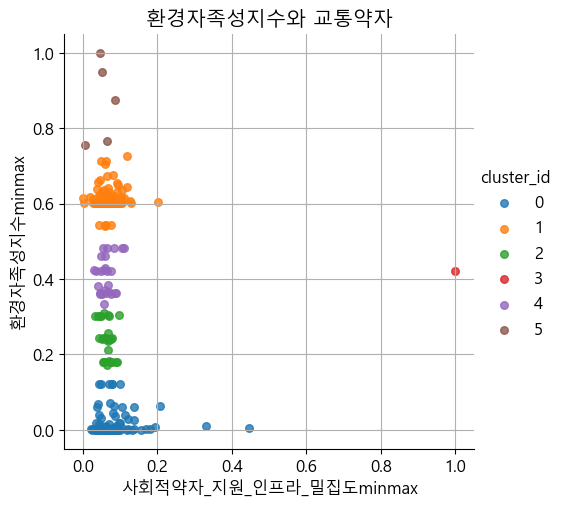

In [96]:
sb.lmplot(x='사회적약자_지원_인프라_밀집도minmax', y='환경자족성지수minmax', data=origin4, 
          fit_reg=False, scatter_kws={"s": 30}, hue="cluster_id")
plt.title("환경자족성지수와 교통약자")
plt.grid()

> - 군집 확인 결과 데이터가 수직으로 분포되어있는 것을 확인. 
> - 지수가 비교적 긍정적인 `3,`, `5` 선정

### 수동 voting을 위한 xlsx 파일 생성

In [97]:
# origin4_final = origin4[(origin4['cluster_id'] == 3) | (origin4['cluster_id'] == 5)]

In [98]:
origin4_final = concat([origin4[origin4['cluster_id'] == 3], origin4[origin4['cluster_id'] == 5]])
origin4_final.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
403,둔촌제1동,0.000000,1.000000,0.000000,0.421500,3
94,면목제4동,0.003249,0.050509,0.074074,0.949815,5
160,중계제4동,0.001636,0.046624,0.043100,1.000000,5
162,상계제1동,0.003907,0.085261,0.071262,0.874020,5
339,양재제1동,0.005750,0.063460,0.131156,0.766479,5


In [99]:
# origin4_final.to_excel('./교집합결과/사회적약자,환경자족성지수voting1.xlsx')

### #3. `환경자족성지수 - 접근성지수`

#### 지수 추출

In [100]:
origin2.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,청운효자동,0.002648,0.068435,0.114798,0.212495
1,사직동,0.006464,0.041923,0.333275,0.038269
2,삼청동,0.005332,0.090426,0.342620,0.602143
3,부암동,0.001699,0.067935,0.157400,0.602143
4,평창동,0.000529,0.073234,0.135935,0.602861


In [101]:
origin5=origin2.copy()
Z = origin5.iloc[:,[-1,-2]].values # x값으로 환경자족성지수,접근성지수 지정
Z[:5]

array([[0.21249473, 0.11479751],
       [0.03826857, 0.33327467],
       [0.60214289, 0.34262014],
       [0.60214289, 0.15739974],
       [0.60286054, 0.13593454]])

#### 엘보우 메소드로 최적의 k값 예상

<Axes: >

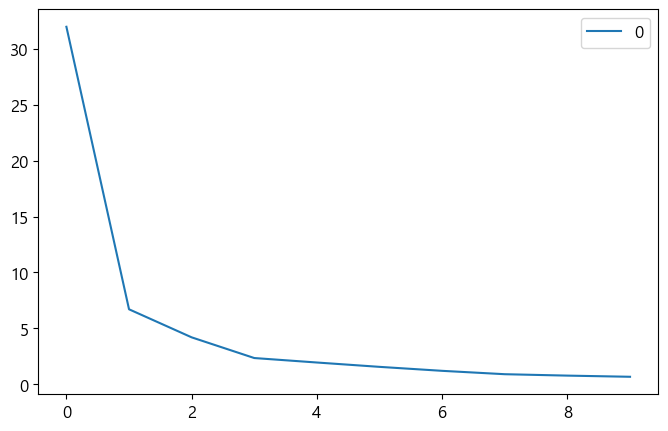

In [102]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k,n_init=10,max_iter=100).fit(Z)
    value = kmeans.inertia_
    inertia.append(value)

DataFrame(inertia).plot()

> 엘보우 그래프 확인 결과 4개에서 완만히 떨어지는 것으로 판단하여 군집수는 4개로 결정

#### 실루엣 스코어로 최적의 k값 예상

In [103]:
origin5_5=origin5.drop('읍면동명',axis=1)

실루엣 점수: 0.649


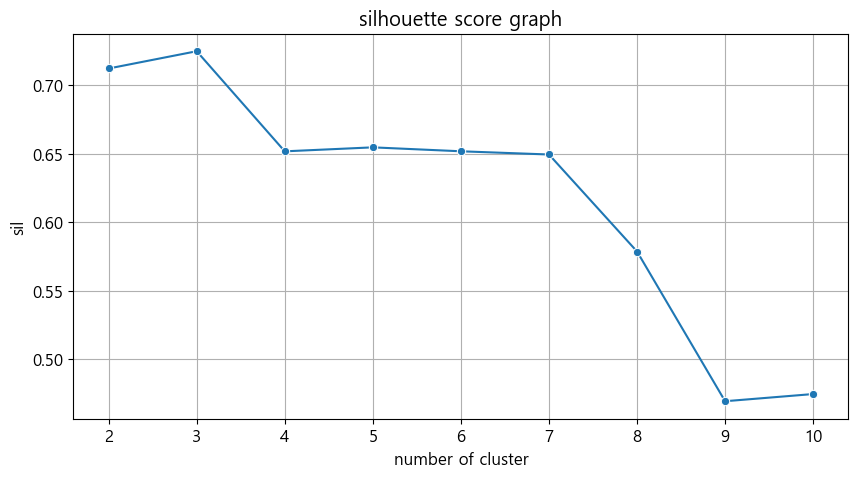

In [104]:
# n_clusters : 군집의 갯수, n_init : 초기 중심위치 수
kmeans=KMeans(n_clusters=4,n_init=10,max_iter=100)
kmeans.fit(origin5_5)
y_pred=kmeans.predict(origin5_5)
score=silhouette_score(origin5_5,y_pred)

print("실루엣 점수: {0:.3f}".format(score))

score_list2=[]

for k in range(2,11):
    kmeans=KMeans(n_clusters=k,n_init=10,max_iter=100)
    kmeans.fit(origin5_5)
    y_pred=kmeans.predict(origin5_5)
    score=silhouette_score(origin5_5,y_pred)
    score_list2.append(score)

score_list2

plt.figure(figsize=(10,5))
sb.lineplot(x=range(2,11),y=score_list2,marker='o')
plt.title('silhouette score graph')
plt.xlabel('number of cluster')
plt.ylabel('sil')
plt.grid()
plt.show()
plt.close()

> 실루엣 스코어 확인 결과 군집을 3으로 설정했을 때 가장 높은 점수가 나옴. <br/> 군집을 3개로 설정한 경우 각 군집별로 필요 이상의 지역 변수가 포함됨을 확인해 군집 수를 6으로 결정.

#### `n_clusters=6`으로 KMeans 군집 군석을 진행

In [105]:
kmeans = KMeans(n_clusters=6,n_init=10,max_iter=100).fit(Z) #군집 4개로 나누겠다
origin5['cluster_id'] = kmeans.labels_
origin5.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
0,청운효자동,0.002648,0.068435,0.114798,0.212495,4
1,사직동,0.006464,0.041923,0.333275,0.038269,3
2,삼청동,0.005332,0.090426,0.342620,0.602143,5
3,부암동,0.001699,0.067935,0.157400,0.602143,0
4,평창동,0.000529,0.073234,0.135935,0.602861,0


c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


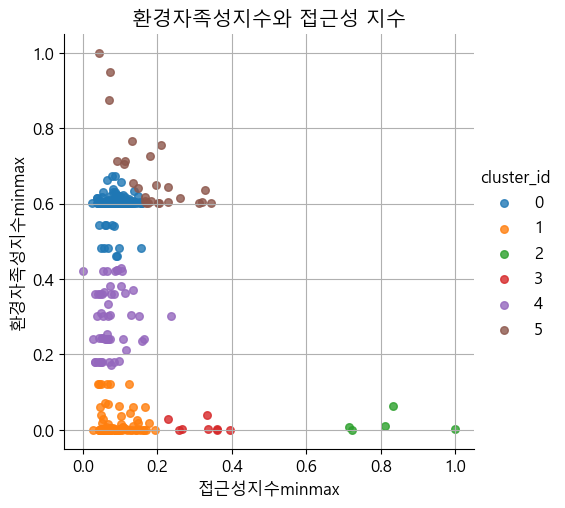

In [106]:
sb.lmplot(x='접근성지수minmax', y='환경자족성지수minmax', data=origin5, 
          fit_reg=False, scatter_kws={"s": 30}, hue="cluster_id")
plt.title("환경자족성지수와 접근성 지수")
plt.grid()

> - 두 지수 값 모두 비교적 긍정적으로 분포된 군집 `4`와 `2`를 분석에 사용하기로 결정

> 접근성지수와 환경자족성지수가 비교적 긍정적이면서 군집이 산발적이지 않은 `0` 지역을 이상적인 지역으로 판단하기로 결정.

### 수동 voting을 위한 xlsx 파일 생성

In [107]:
len(origin5[origin5['cluster_id']==4])
len(origin5[origin5['cluster_id']==2])

5

In [108]:
origin5_final=origin5[(origin5['cluster_id']==2)|(origin5['cluster_id']==4)]
origin5_final.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
0,청운효자동,0.002648,0.068435,0.114798,0.212495,4
8,종로1.2.3.4가동,0.069040,0.206536,0.831703,0.063833,2
15,숭인제1동,0.000000,0.060028,0.134867,0.370980,4
17,소공동,0.085553,0.331262,0.811509,0.009355,2
18,회현동,0.294433,0.155671,0.722658,0.000000,2


In [109]:
# origin5_final.to_excel('./교집합결과/접근성지수,환경자족성지수voting1.xlsx')

### #4. `여가생활지수 - 사회적약자_지원_인프라_밀집도`

In [110]:
origin2.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,청운효자동,0.002648,0.068435,0.114798,0.212495
1,사직동,0.006464,0.041923,0.333275,0.038269
2,삼청동,0.005332,0.090426,0.342620,0.602143
3,부암동,0.001699,0.067935,0.157400,0.602143
4,평창동,0.000529,0.073234,0.135935,0.602861


In [111]:
origin6=origin2.copy()
XX = origin6.iloc[:,[1,2]].values #x값으로 여가생활지수,사회적약자_지원_인프라_밀집도 지정
XX[:5]

array([[0.00264752, 0.06843491],
       [0.00646393, 0.04192329],
       [0.00533217, 0.09042634],
       [0.0016987 , 0.06793525],
       [0.00052877, 0.0732343 ]])

#### 엘보우 메소드로 최적의 k값 예상

<Axes: >

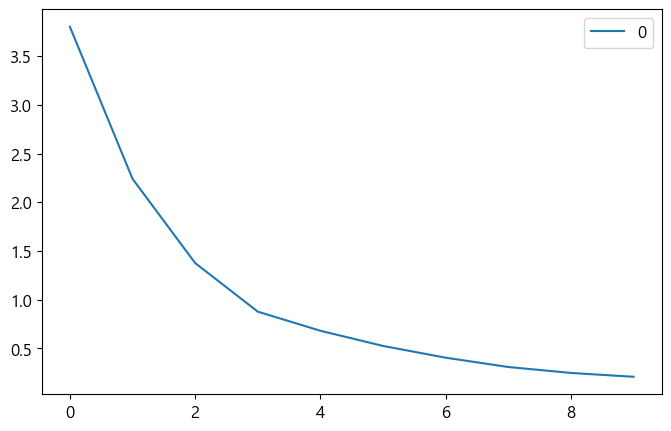

In [112]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k,n_init=10,max_iter=100).fit(XX)
    value = kmeans.inertia_
    inertia.append(value)

DataFrame(inertia).plot()

> 엘보우 그래프 확인 결과 군집이 4개에서 완만히 떨어지는 것으로 판단하여 군집수는 `4`로 결정

#### 실루엣 스코어로 최적의 k값 예상

In [113]:
origin6_6=origin6.drop('읍면동명',axis=1)

실루엣 점수: 0.652


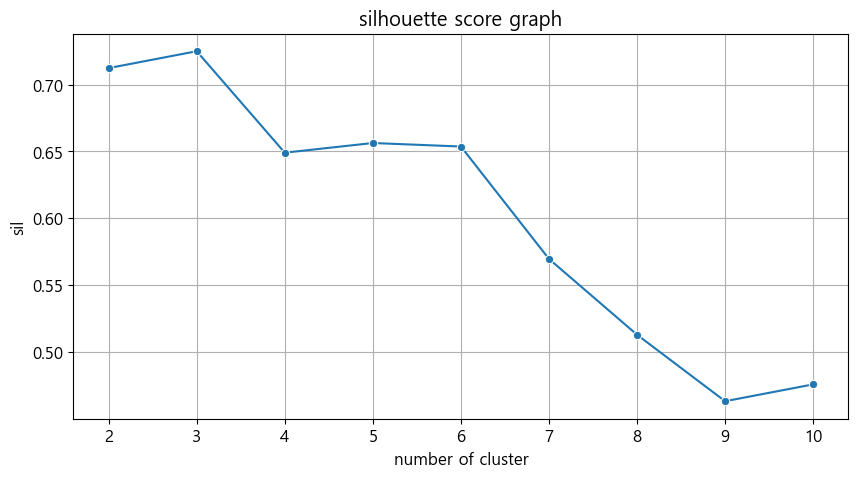

In [114]:
kmeans=KMeans(n_clusters=4,n_init=10,max_iter=100)
kmeans.fit(origin6_6)
y_pred=kmeans.predict(origin6_6)
score=silhouette_score(origin6_6,y_pred)

print("실루엣 점수: {0:.3f}".format(score))

score_list3=[]

for k in range(2,11):
    kmeans=KMeans(n_clusters=k,n_init=10,max_iter=100)
    kmeans.fit(origin6_6)
    y_pred=kmeans.predict(origin6_6)
    score=silhouette_score(origin6_6,y_pred)
    score_list3.append(score)

score_list3

plt.figure(figsize=(10,5))
sb.lineplot(x=range(2,11),y=score_list3,marker='o')
plt.title('silhouette score graph')
plt.xlabel('number of cluster')
plt.ylabel('sil')
plt.grid()
plt.show()
plt.close()

> 실루엣 스코어 확인 결과 군집을 3개로 설정했을 때 가장 높은 점수가 나와 3으로 설정하는 것이 타당. <br/> 다만, 군집을 3개로 설정한 경우 각 군집별로 필요 이상의 지역 변수가 포함됨을 확인해 군집 수를 6으로 결정.

#### `n_clusters=6`으로 KMeans 군집 군석을 진행

In [115]:
kmeans = KMeans(n_clusters=6,n_init=10,max_iter=100).fit(XX) #군집 3개로 나누겠다
origin6['cluster_id'] = kmeans.labels_
origin6.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
0,청운효자동,0.002648,0.068435,0.114798,0.212495,0
1,사직동,0.006464,0.041923,0.333275,0.038269,0
2,삼청동,0.005332,0.090426,0.342620,0.602143,0
3,부암동,0.001699,0.067935,0.157400,0.602143,0
4,평창동,0.000529,0.073234,0.135935,0.602861,0


c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


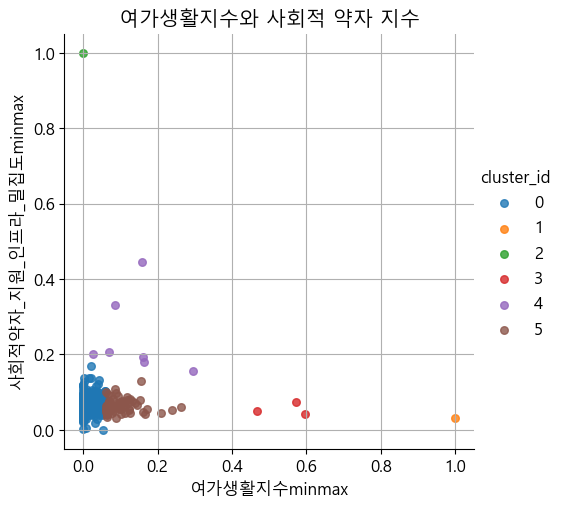

In [116]:
sb.lmplot(x='여가생활지수minmax', y='사회적약자_지원_인프라_밀집도minmax', data=origin6, 
          fit_reg=False, scatter_kws={"s": 30}, hue="cluster_id")
plt.title("여가생활지수와 사회적 약자 지수")
plt.grid()

> 군집 확인 결과 `1`, `2`번 군집의 경우 데이터가 없어서 정상적인 군집이라고 판단하기 어려움. <br/> 그러나 각각 높은 수치의 지수 값을 나타내고 있음.

### 수동 voting을 위한 xlsx 파일 생성

In [117]:
len(origin6[(origin6['cluster_id'] == 1)])
origin6[(origin6['cluster_id'] == 2)]

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
403,둔촌제1동,0.0,1.0,0.0,0.4215,2


In [118]:
origin6_final=origin6[(origin6['cluster_id'] == 1) | (origin6['cluster_id'] == 2)]
origin6_final.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
24,신당동,1.0,0.03149,0.235243,0.301071,1
403,둔촌제1동,0.0,1.00000,0.000000,0.421500,2


In [119]:
# origin6_final.to_excel('./교집합결과/여가생활,사회적약자voting1.xlsx')

### #5. `여가생활지수 - 접근성지수`

In [120]:
origin2.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,청운효자동,0.002648,0.068435,0.114798,0.212495
1,사직동,0.006464,0.041923,0.333275,0.038269
2,삼청동,0.005332,0.090426,0.342620,0.602143
3,부암동,0.001699,0.067935,0.157400,0.602143
4,평창동,0.000529,0.073234,0.135935,0.602861


In [121]:
origin7=origin2.copy()
YY = origin7.iloc[:,[1,-2]].values #x값으로 여가생활지수,접근성지수 지정
YY[:5]

array([[0.00264752, 0.11479751],
       [0.00646393, 0.33327467],
       [0.00533217, 0.34262014],
       [0.0016987 , 0.15739974],
       [0.00052877, 0.13593454]])

#### 엘보우 메소드로 최적의 k값 예상

<Axes: >

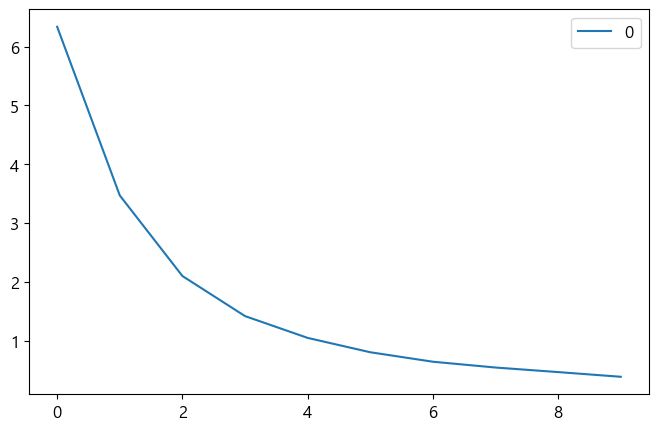

In [122]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k,n_init=10,max_iter=100).fit(YY)
    value = kmeans.inertia_
    inertia.append(value)

DataFrame(inertia).plot()

> 엘보우 그래프 확인 결과 군집이 4일 경우 비교적 완만하게 떨어지는 것으로 보여 군집 수는 4개로 결정

#### 실루엣 스코어로 최적의 k값 예상

In [123]:
origin7_7=origin7.drop('읍면동명',axis=1)

실루엣 점수: 0.654


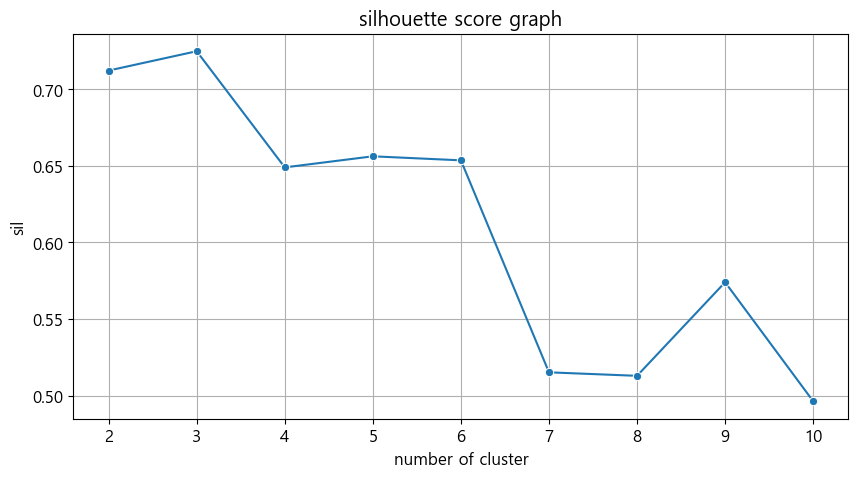

In [124]:
kmeans=KMeans(n_clusters=6,n_init=10,max_iter=100)
kmeans.fit(origin7_7)
y_pred=kmeans.predict(origin7_7)
score=silhouette_score(origin7_7,y_pred)

print("실루엣 점수: {0:.3f}".format(score))

score_list4=[]

for k in range(2,11):
    kmeans=KMeans(n_clusters=k,n_init=10,max_iter=100)
    kmeans.fit(origin7_7)
    y_pred=kmeans.predict(origin7_7)
    score=silhouette_score(origin7_7,y_pred)
    score_list4.append(score)

score_list4

plt.figure(figsize=(10,5))
sb.lineplot(x=range(2,11),y=score_list4,marker='o')
plt.title('silhouette score graph')
plt.xlabel('number of cluster')
plt.ylabel('sil')
plt.grid()
plt.show()
plt.close()

> 실루엣 그래프 확인 결과 마찬가지로 군집수를 4로 설정했을 때 가장 높은 점수를 보여 4로 결정 <br/> 추가 분석 결과 군집을 4개로 설정한 경우 각 군집별로 필요 이상의 지역 변수가 포함됨을 확인해 군집 수를 6으로 결정.

#### `n_clusters=3`으로 KMeans 군집 군석을 진행

In [125]:
kmeans = KMeans(n_clusters=3,n_init=10,max_iter=100).fit(YY) #군집 4개로 나누겠다
origin7['cluster_id'] = kmeans.labels_
origin7.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
0,청운효자동,0.002648,0.068435,0.114798,0.212495,0
1,사직동,0.006464,0.041923,0.333275,0.038269,0
2,삼청동,0.005332,0.090426,0.342620,0.602143,0
3,부암동,0.001699,0.067935,0.157400,0.602143,0
4,평창동,0.000529,0.073234,0.135935,0.602861,0


c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


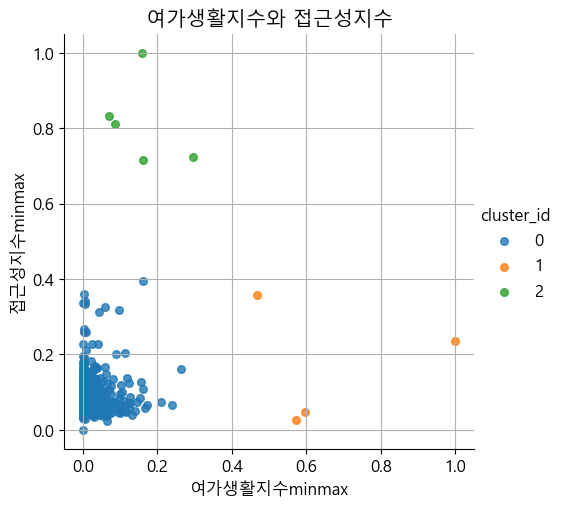

In [126]:
sb.lmplot(x='여가생활지수minmax', y='접근성지수minmax', data=origin7, 
          fit_reg=False, scatter_kws={"s": 30}, hue="cluster_id")
plt.title("여가생활지수와 접근성지수")
plt.grid()

> - 군집 확인 결과 군집의 쏠림 현상이 확인됨.
> - 두 지수 모두 비교적 긍정적으로 분포한 `1`, `2`번 군집이 가장 적합하다고 판단해 두 군집을 분석 자료로 선정

### 수동 voting을 위한 xlsx 파일 생성

In [127]:
# len(origin7[origin7['cluster_id']==1])
len(origin7[origin7['cluster_id']==2])

5

In [128]:
origin7_final=origin7[(origin7['cluster_id']==1)|(origin7['cluster_id']==2)]
origin7_final.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
8,종로1.2.3.4가동,0.069040,0.206536,0.831703,0.063833,2
17,소공동,0.085553,0.331262,0.811509,0.009355,2
18,회현동,0.294433,0.155671,0.722658,0.000000,2
19,명동,0.158472,0.445774,1.000000,0.003588,2
22,광희동,0.467260,0.051345,0.358815,0.001183,1


In [129]:
# origin7_final.to_excel('./교집합결과/여가생활,접근성지수voting1.xlsx')

### #6. `사회적약자_지원_인프라_밀집도 - 접근성지수`

In [130]:
origin2.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,청운효자동,0.002648,0.068435,0.114798,0.212495
1,사직동,0.006464,0.041923,0.333275,0.038269
2,삼청동,0.005332,0.090426,0.342620,0.602143
3,부암동,0.001699,0.067935,0.157400,0.602143
4,평창동,0.000529,0.073234,0.135935,0.602861


In [131]:
origin8=origin2.copy()
ZZ = origin8.iloc[:,[2,-2]].values #x값으로 교통약자,접근성지수 지정
ZZ[:5]

array([[0.06843491, 0.11479751],
       [0.04192329, 0.33327467],
       [0.09042634, 0.34262014],
       [0.06793525, 0.15739974],
       [0.0732343 , 0.13593454]])

#### 엘보우 메소드로 최적의 k값 예상

<Axes: >

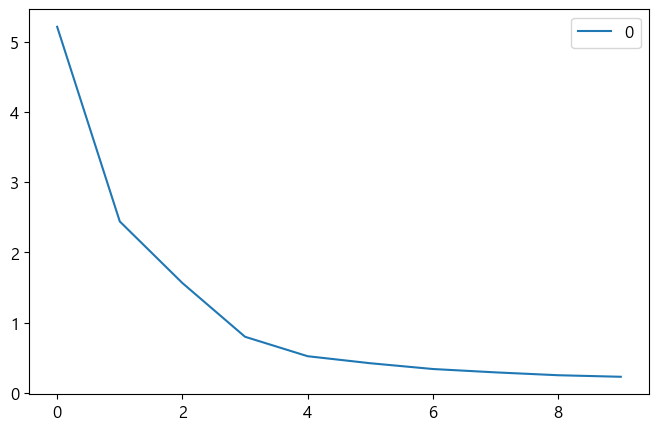

In [132]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k,n_init=10,max_iter=100).fit(ZZ)
    value = kmeans.inertia_
    inertia.append(value)

DataFrame(inertia).plot()

> 엘보우 그래프 확인 결과 4개 즈음에 완만하게 떨어지는것으로 보여지나 확실하지 않아 실루엣 그래프로 재확인

#### 실루엣 스코어로 최적의 k값 예상

In [133]:
origin8_8=origin8.drop('읍면동명',axis=1)

실루엣 점수: 0.649


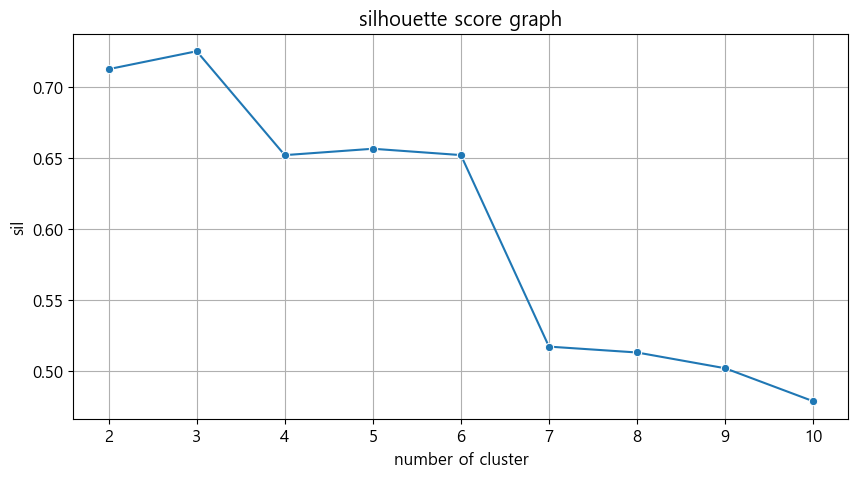

In [134]:
kmeans=KMeans(n_clusters=4,n_init=10,max_iter=100)
kmeans.fit(origin8_8)
y_pred=kmeans.predict(origin8_8)
score=silhouette_score(origin8_8,y_pred)

print("실루엣 점수: {0:.3f}".format(score))

score_list5=[]

for k in range(2,11):
    kmeans=KMeans(n_clusters=k,n_init=10,max_iter=100)
    kmeans.fit(origin8_8)
    y_pred=kmeans.predict(origin8_8)
    score=silhouette_score(origin8_8,y_pred)
    score_list5.append(score)

score_list5

plt.figure(figsize=(10,5))
sb.lineplot(x=range(2,11),y=score_list5,marker='o')
plt.title('silhouette score graph')
plt.xlabel('number of cluster')
plt.ylabel('sil')
plt.grid()
plt.show()
plt.close()

> 실루엣 스코어 확인 결과 군집을 3개로 설정했을 때 가장 높은 점수가 나와 3으로 결정 <br/> 추가 분석 결과 군집을 3개로 설정한 경우 각 군집별로 필요 이상의 지역 변수가 포함됨을 확인해 군집 수를 지역 변수가 이상적으로 나누어지는 5로 결정.

In [135]:
kmeans = KMeans(n_clusters=6,n_init=10,max_iter=100).fit(ZZ)
origin8['cluster_id'] = kmeans.labels_
origin8.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
0,청운효자동,0.002648,0.068435,0.114798,0.212495,4
1,사직동,0.006464,0.041923,0.333275,0.038269,5
2,삼청동,0.005332,0.090426,0.342620,0.602143,5
3,부암동,0.001699,0.067935,0.157400,0.602143,0
4,평창동,0.000529,0.073234,0.135935,0.602861,0


c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


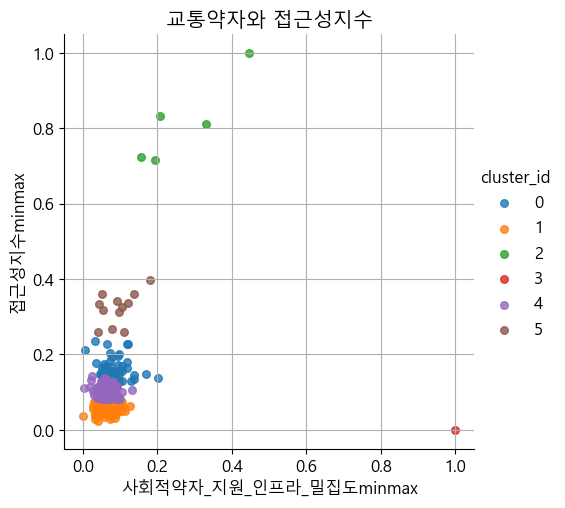

In [136]:
sb.lmplot(x='사회적약자_지원_인프라_밀집도minmax', y='접근성지수minmax', data=origin8, 
          fit_reg=False, scatter_kws={"s": 30}, hue="cluster_id")
plt.title("교통약자와 접근성지수")
plt.grid()

>군집 `1`, `2`, `5`를 분석에 사용

### 수동 voting을 위한 xlsx 파일 생성

In [137]:
origin8[origin8['cluster_id']==1]
# origin8[origin8['cluster_id']==2]
# origin8[origin8['cluster_id']==5]

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
5,무악동,0.015668,0.038406,0.049987,0.001360,1
13,창신제2동,0.000000,0.026829,0.054825,0.001863,1
16,숭인제2동,0.165488,0.042236,0.058096,0.603068,1
25,다산동,0.001970,0.053537,0.072677,0.000208,1
27,청구동,0.006301,0.033702,0.027959,0.000164,1
...,...,...,...,...,...,...
396,천호제1동,0.041372,0.076400,0.042926,0.000214,1
397,천호제2동,0.044977,0.057228,0.064406,0.603396,1
398,천호제3동,0.000328,0.037942,0.046723,0.060334,1
401,성내제3동,0.041755,0.075533,0.079180,0.542149,1


In [138]:
origin8_final=origin8[(origin8['cluster_id']==1)|(origin8['cluster_id']==2)|(origin8['cluster_id']==1)|(origin8['cluster_id']==5)]
origin8_final.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax,cluster_id
1,사직동,0.006464,0.041923,0.333275,0.038269,5
2,삼청동,0.005332,0.090426,0.342620,0.602143,5
5,무악동,0.015668,0.038406,0.049987,0.001360,1
7,가회동,0.003559,0.078064,0.266902,0.003047,5
8,종로1.2.3.4가동,0.069040,0.206536,0.831703,0.063833,2


In [139]:
# origin8_final.to_excel('./교집합결과/사회적약자,접근성지수voting1.xlsx')